In [ ]:
# !unzip /content/images_background_small1.zip
!unzip /content/images_background.zip

!unzip /content/images_evaluation.zip

Streaming output truncated to the last 5000 lines.
  inflating: images_evaluation/Mongolian/character28/1386_05.png  
  inflating: images_evaluation/Mongolian/character28/1386_06.png  
  inflating: images_evaluation/Mongolian/character28/1386_07.png  
  inflating: images_evaluation/Mongolian/character28/1386_08.png  
  inflating: images_evaluation/Mongolian/character28/1386_09.png  
  inflating: images_evaluation/Mongolian/character28/1386_10.png  
  inflating: images_evaluation/Mongolian/character28/1386_11.png  
  inflating: images_evaluation/Mongolian/character28/1386_12.png  
  inflating: images_evaluation/Mongolian/character28/1386_13.png  
  inflating: images_evaluation/Mongolian/character28/1386_14.png  
  inflating: images_evaluation/Mongolian/character28/1386_15.png  
  inflating: images_evaluation/Mongolian/character28/1386_16.png  
  inflating: images_evaluation/Mongolian/character28/1386_17.png  
  inflating: images_evaluation/Mongolian/character28/1386_18.png  
  inflating

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
from numpy.random import choice as npc
import numpy as np
import time
import random
import torchvision.datasets as dset
from PIL import Image


class OmniglotTrain(Dataset):

    def __init__(self, dataPath, transform=None):
        super(OmniglotTrain, self).__init__()
        np.random.seed(0)
        # self.dataset = dataset
        self.transform = transform
        self.datas, self.num_classes = self.loadToMem(dataPath)

    def loadToMem(self, dataPath):
        print("begin loading training dataset to memory")
        datas = {}
        agrees = [0, 90, 180, 270]
        idx = 0
        for agree in agrees:
            for alphaPath in os.listdir(dataPath):
                for charPath in os.listdir(os.path.join(dataPath, alphaPath)):
                    datas[idx] = []
                    for samplePath in os.listdir(os.path.join(dataPath, alphaPath, charPath)):
                        filePath = os.path.join(dataPath, alphaPath, charPath, samplePath)
                        datas[idx].append(Image.open(filePath).rotate(agree).convert('L'))
                    idx += 1
        print("finish loading training dataset to memory")
        return datas, idx

    def __len__(self):
        return  21000000

    def __getitem__(self, index):
        # image1 = random.choice(self.dataset.imgs)
        label = None
        img1 = None
        img2 = None
        # get image from same class
        if index % 2 == 1:
            label = 1.0
            idx1 = random.randint(0, self.num_classes - 1)
            image1 = random.choice(self.datas[idx1])
            image2 = random.choice(self.datas[idx1])
        # get image from different class
        else:
            label = 0.0
            idx1 = random.randint(0, self.num_classes - 1)
            idx2 = random.randint(0, self.num_classes - 1)
            while idx1 == idx2:
                idx2 = random.randint(0, self.num_classes - 1)
            image1 = random.choice(self.datas[idx1])
            image2 = random.choice(self.datas[idx2])

        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        return image1, image2, torch.from_numpy(np.array([label], dtype=np.float32))


class OmniglotTest(Dataset):

    def __init__(self, dataPath, transform=None, times=200, way=20):
        np.random.seed(1)
        super(OmniglotTest, self).__init__()
        self.transform = transform
        self.times = times
        self.way = way
        self.img1 = None
        self.c1 = None
        self.datas, self.num_classes = self.loadToMem(dataPath)

    def loadToMem(self, dataPath):
        print("begin loading test dataset to memory")
        datas = {}
        idx = 0
        for alphaPath in os.listdir(dataPath):
            for charPath in os.listdir(os.path.join(dataPath, alphaPath)):
                datas[idx] = []
                for samplePath in os.listdir(os.path.join(dataPath, alphaPath, charPath)):
                    filePath = os.path.join(dataPath, alphaPath, charPath, samplePath)
                    datas[idx].append(Image.open(filePath).convert('L'))
                idx += 1
        print("finish loading test dataset to memory")
        return datas, idx

    def __len__(self):
        return self.times * self.way

    def __getitem__(self, index):
        idx = index % self.way
        label = None
        # generate image pair from same class
        if idx == 0:
            self.c1 = random.randint(0, self.num_classes - 1)
            self.img1 = random.choice(self.datas[self.c1])
            img2 = random.choice(self.datas[self.c1])
        # generate image pair from different class
        else:
            c2 = random.randint(0, self.num_classes - 1)
            while self.c1 == c2:
                c2 = random.randint(0, self.num_classes - 1)
            img2 = random.choice(self.datas[c2])

        if self.transform:
            img1 = self.transform(self.img1)
            img2 = self.transform(img2)
        return img1, img2


# # test
# if __name__=='__main__':
#     omniglotTrain = OmniglotTrain('./images_background', 30000*8)
#     print(omniglotTrain)


In [ ]:
# cuda.is_available()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Siamese(nn.Module):

    def __init__(self):
        super(Siamese, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1: 1@105x105 → 64@96x96
            nn.Conv2d(1, 64, 10),  # 64@96*96
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 64@48*48

            # Layer 2: 64@48x48 → 128@42x42
            nn.Conv2d(64, 128, 7),
            nn.ReLU(),    # 128@42*42
            nn.MaxPool2d(2),   # 128@21*21

            # Layer 3: 128@21x21 → 128@18x18
            nn.Conv2d(128, 128, 4),
            nn.ReLU(), # 128@18*18
            nn.MaxPool2d(2), # 128@9*9

            # Layer 4: 128@9x9 → 256@6x6
            nn.Conv2d(128, 256, 4),
            nn.ReLU(),   # 256@6*6
        )
        self.liner = nn.Sequential(nn.Linear(9216, 4096), nn.Sigmoid()) # Flatten 256@6x6 = 9216 → 4096, sigmoid normalizes to [0, 1]
        self.out = nn.Linear(4096, 1) #output

    def forward_one(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.liner(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        dis = torch.abs(out1 - out2)
        out = self.out(dis)
        #  return self.sigmoid(out)
        return out

# for test
if __name__ == '__main__':
    net = Siamese()
    print(net)
    print(list(net.parameters()))


Siamese(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (10): ReLU()
  )
  (liner): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): Sigmoid()
  )
  (out): Linear(in_features=4096, out_features=1, bias=True)
)
[Parameter containing:
tensor([[[[-8.2081e-02,  3.3001e-03,  5.6560e-02,  ...,  4.2271e-02,
            5.0065e-02,  9.3917e-02],
          [ 7.6399e-02, -9.6092e-02,  9.3373e-03,  ...,  2.4187e-02,
           -9.0850e-02

Using device: cuda
begin loading training dataset to memory
finish loading training dataset to memory
begin loading test dataset to memory
finish loading test dataset to memory


  0%|          | 0/50000 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
[11580]	loss:	0.06564	time lapsed:	0.42 s
[11590]	loss:	0.07390	time lapsed:	0.42 s
[11600]	loss:	0.08554	time lapsed:	0.43 s
**********************************************************************
[11600]	Test set	correct:	348	error:	52	precision:	0.87
**********************************************************************
[11610]	loss:	0.06897	time lapsed:	3.28 s
[11620]	loss:	0.08067	time lapsed:	0.43 s
[11630]	loss:	0.09244	time lapsed:	0.43 s
[11640]	loss:	0.07390	time lapsed:	0.42 s
[11650]	loss:	0.06059	time lapsed:	0.42 s
[11660]	loss:	0.07408	time lapsed:	0.42 s
[11670]	loss:	0.07949	time lapsed:	0.42 s
[11680]	loss:	0.06012	time lapsed:	0.42 s
[11690]	loss:	0.08016	time lapsed:	0.42 s
[11700]	loss:	0.06941	time lapsed:	0.43 s
**********************************************************************
[11700]	Test set	correct:	349	error:	51	precision:	0.8725
**********************************************************************
[1171

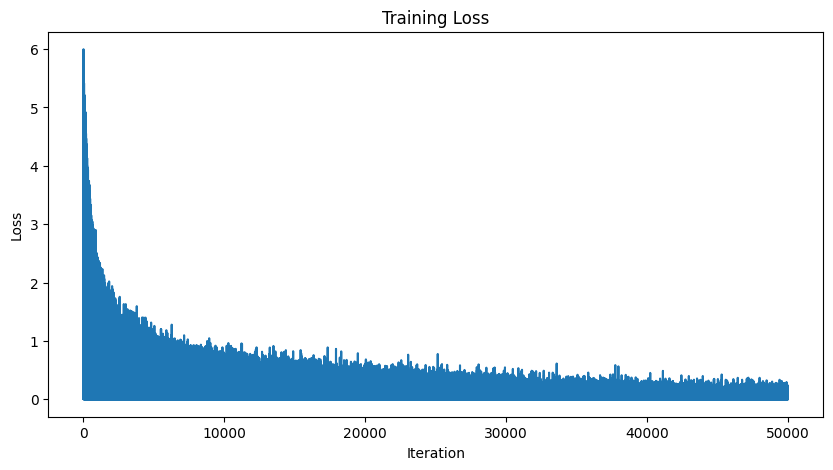

In [ ]:
import torch
import pickle
import torchvision
from torchvision import transforms
import torchvision.datasets as dset
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import numpy as np
from collections import deque
import os
from tqdm.notebook import tqdm

# Configuration
class Config:
    cuda = torch.cuda.is_available()
    train_path = "/content/images_background"
    test_path = "/content/images_evaluation"
    way = 20
    times = 400
    workers = 12
    batch_size = 128
    lr = 0.001
    show_every = 10
    save_every = 100
    test_every = 100
    max_iter = 50000
    model_path = "models"
    lr_min = 0.00001
    lr_scheduler = 'cosine'

# Create model directory
os.makedirs(Config.model_path, exist_ok=True)

# Setup device
device = torch.device('cuda' if Config.cuda else 'cpu')
print(f"Using device: {device}")

# Data transforms
# data_transforms = transforms.Compose([
#     transforms.RandomAffine(15),
#     transforms.ToTensor()
# ])

data_transforms = transforms.Compose([transforms.RandomAffine(degrees = 15, #Radnom rotation +-15 degrees
                             translate=(3/105, 3/105)), # 3 pixel translation in any direction (image size is 105x105)
                                      transforms.ToTensor()])

# Setup datasets and loaders
trainSet = OmniglotTrain(Config.train_path, transform=data_transforms)
testSet = OmniglotTest(Config.test_path, transform=transforms.ToTensor(),
                       times=Config.times, way=Config.way)

trainLoader = DataLoader(trainSet, batch_size=Config.batch_size,
                        shuffle=False, num_workers=Config.workers)
testLoader = DataLoader(testSet, batch_size=Config.way,
                       shuffle=False, num_workers=Config.workers)

# Initialize model
net = Siamese()
if Config.cuda:
    net = net.cuda()
net.train()

# Loss and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=Config.lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = Config.max_iter, eta_min =0)

# Training loop
train_loss = []
loss_val = 0
time_start = time.time()
queue = deque(maxlen=20)

progress_bar = tqdm(enumerate(trainLoader, 1), total=Config.max_iter)
for batch_id, (img1, img2, label) in progress_bar:
    if batch_id > Config.max_iter:
        break

    # Move to device
    img1, img2, label = img1.to(device), img2.to(device), label.to(device)

    # Forward pass
    optimizer.zero_grad()
    output = net(img1, img2)
    loss = loss_fn(output, label)
    loss_val += loss.item()

    # Backward pass
    loss.backward()
    optimizer.step()

    #scheduler step
    scheduler.step()

    #get current learning rate
    current_lr = scheduler.get_last_lr()[0]

    # Update progress
    progress_bar.set_description(f"Loss: {loss_val/(batch_id%Config.show_every + 1):.5f} LR: {current_lr:.6f}")

    if batch_id % Config.show_every == 0:
        print(f'[{batch_id}]\tloss:\t{loss_val/Config.show_every:.5f}\t'
              f'time lapsed:\t{time.time() - time_start:.2f} s')
        loss_val = 0
        time_start = time.time()

    if batch_id % Config.save_every == 0:
        torch.save(net.state_dict(),
                  f'{Config.model_path}/model-inter-{batch_id+1}.pt')

    if batch_id % Config.test_every == 0:
        net.eval()
        right, error = 0, 0
        with torch.no_grad():
            for _, (test1, test2) in enumerate(testLoader, 1):
                # 20-way one-shot task:
                # test1 = anchor image
                # test2 = 20 test images (1 matching, 19 different)
                test1, test2 = test1.to(device), test2.to(device)
                output = net(test1, test2).cpu().numpy()
                pred = np.argmax(output)
                if pred == 0:
                    right += 1
                else:
                    error += 1

        print('*'*70)
        precision = right*1.0/(right+error)
        print(f'[{batch_id}]\tTest set\tcorrect:\t{right}\terror:\t{error}\t'
              f'precision:\t{precision}')
        print('*'*70)
        queue.append(precision)
        net.train()

    train_loss.append(loss_val)

# Save training loss
with open('train_loss.pkl', 'wb') as f:
    pickle.dump(train_loss, f)

# Final accuracy
acc = sum(queue)/len(queue)
print("#"*70)
print(f"Final accuracy: {acc:.4f}")

# Plot training loss
plt.figure(figsize=(10,5))
plt.plot(train_loss)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

anchor = character_A_img
test_images = [
    character_A_different_img,  # Should match (position 0)
    character_B_img,
    character_C_img,
    # ... 17 more different character images
]
# Network should output highest similarity for position 0